In [123]:
# standard lib:
import heapq
import pathlib
import glob
import os

# ML/data science libraries:
import numpy as np
from scipy import spatial
import pandas as pd

# TenserFlow/Keras classes:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalMaxPool2D

# plotting and imaging:
import cv2
import matplotlib.pyplot as plt

## Load and Process Images:

In [112]:
# n.b. we don't need to sort since we're not training the model:
def get_file_paths():
    """ Create generator of all image file paths.

    :return {generator}
    """

    # We could also have used `pathlib.Path().glob()`, but that returns a POSIX path rather than str:
    return glob.iglob('../data/e-commerce-product-images/**/*.jpg', recursive=True)

file_paths = get_file_paths()

## Explore Data -- i.e. images:
N.b. the dataset includes different size images and images with different number of channels (i.e. both RGB and grayscale) images.

AxesImage(54,36;334.8x217.44)


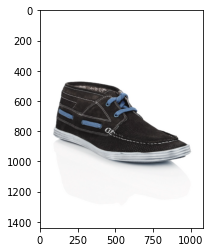

In [113]:
example_img = cv2.imread(next(file_paths))
print(plt.imshow(example_img))

# reset generator:
file_paths = get_file_paths()

## Load ResNet Model:

In [114]:
# constants:
IMG_HEIGHT  = 224
IMG_WIDTH   = 224

resnet_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
resnet_model.trainable = False

resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [115]:
# Update the model by adding a global max pooling layer:
# In essence, we replaced the last couple layers of the original ResNet model with a layer that outputs the embedding/features of the image.
# Recall that global pooling always reduces the output to be shape 1 x 1 x channels; essentially, outputting a layer of feature-maps.
model = Sequential([
    resnet_model,
    GlobalMaxPool2D()
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
Total params: 23,564,800
Trainable params: 0
Non-trainable params: 23,564,800
_________________________________________________________________


**Aside:** if we didn't specify `include_top=False` in `resnet_model` from the previous two cells,
we could alternatively have created a new model and get the last 3rd to last layer:
```
resnet_model_ = ResNet50V2(weights='imagenet')
```

This would, however, result in the exact same model:
```
feature_extraction_model = Model(
    name='ResNet50V2_ExtractFeature',
    inputs=resnet_model_.inputs,
    outputs=resnet_model_.get_layer('post_relu').output
)
```

In [116]:
# Helper methods:

def cosine_similarity(embedding_1:np.ndarray, embedding_2:np.ndarray):
    """ Calculates the cosine similarity of two vectors.

    :param embedding_1: An embedding vector.
    :param embedding_2: An embedding vector.
    :return: A single number (numpy float) -- the cosine similarity value.
    """

    # `distance.cosine` computes distance, not similarity; subtract by 1 to get similarity:
    return 1 - spatial.distance.cosine(embedding_1, embedding_2)

def process_image(img:np.ndarray):
    """ Pre-process images before feeding to model.

    Resizes image, scales (/255), and expands array dimension. The model requires specific input dimensions (shape),
    therefore resizing and adding dimension is necessary. Scaling improves performance.
    TODO: ideally, we should use standard deviation and mean of dataset instead of simply dividing by 255.

    :param img:
    :return {np.ndarray}: returns processed image
    """
    # see comparison of different interpolation methods: <https://chadrick-kwag.net/cv2-resize-interpolation-methods/>
    processed_img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)

    # We can use TF's ResNet `preprocess_input` <https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/preprocess_input>
    # however, because the datasets are quite different, it might do more harm than good <https://stackoverflow.com/a/58250681>;
    # we can therefore, simply divide by 255:
    processed_img = processed_img / 255

    # ResNet model expects input shape (batch_size, img_height, img_width, channels) -- we need to add batch_size dimension:
    processed_img = np.expand_dims(processed_img, axis=0)
    return processed_img

def get_embedding(file_path:str):
    img = cv2.imread(file_path)
    img = process_image(img)
    embedding = model.predict(img)

    return embedding

## Calculate the Embedding Vector and Cosine Similarity:

In [117]:
%%time

df_embeddings = pd.DataFrame(columns=['file', 'file_path', 'embedding'])

# TODO: can we optimize/speed-up this, perhaps via batch processing?
for file_path_ in file_paths:
    embedding_ = get_embedding(file_path_)
    file_name_ = file_path_.split('/')[-1]

    df_embeddings = df_embeddings.append({'file': file_name_, 'file_path': file_path_, 'embedding': embedding_}, ignore_index=True)

CPU times: user 27min 9s, sys: 21.8 s, total: 27min 31s
Wall time: 7min 57s


In [118]:
# write out to file:
df_embeddings.to_csv(pathlib.Path('../data/output/embedding.csv'))

df_embeddings.head()

,file,file_path,embedding
0,35465.jpg,../data/e-commerce-product-images/Footwear/Men...,"[[16.11998, 0.8772273, 1.1345854, 9.337022, 0...."
1,13073.jpg,../data/e-commerce-product-images/Footwear/Men...,"[[8.837439, 0.5547619, 1.0251846, 0.9071655, 0..."
2,6620.jpg,../data/e-commerce-product-images/Footwear/Men...,"[[9.076581, 2.0951161, 2.2368407, 3.334118, 0...."
3,41452.jpg,../data/e-commerce-product-images/Footwear/Men...,"[[3.9208193, 2.109016, 0.9094248, 6.297415, 0...."
4,17960.jpg,../data/e-commerce-product-images/Footwear/Men...,"[[5.9821014, 0.0, 3.3930125, 5.51929, 0.0, 0.0..."


In [119]:
%%time

n_images = len(df_embeddings)
similarity_scores = np.zeros((n_images, n_images))
for i in range(n_images):
    for j in range(n_images):
        similarity_scores[i, j] = cosine_similarity(df_embeddings.iloc[i]['embedding'], df_embeddings.iloc[j]['embedding'])

CPU times: user 30min 27s, sys: 311 ms, total: 30min 27s
Wall time: 30min 26s


In [120]:
# create empty dataframe with file names as both the column and index names:
file_names = df_embeddings.loc[:, 'file'].tolist()
df_similarity = pd.DataFrame(similarity_scores, columns=file_names, index=file_names)

# write out to file:
df_similarity.to_csv(pathlib.Path('../data/output/similarity_scores.csv'))

df_similarity.head()

,35465.jpg,13073.jpg,6620.jpg,41452.jpg,17960.jpg,19123.jpg,22109.jpg,12705.jpg,31947.jpg,7396.jpg,...,40131.jpg,10649.jpg,52122.jpg,39864.jpg,36717.jpg,13306.jpg,37199.jpg,38248.jpg,31099.jpg,5412.jpg
35465.jpg,1.000000,0.613709,0.690094,0.650145,0.627233,0.528594,0.636214,0.682517,0.779383,0.737546,...,0.349740,0.272385,0.375551,0.286901,0.302112,0.332130,0.346382,0.325094,0.307653,0.333002
13073.jpg,0.613709,1.000000,0.722704,0.716795,0.546889,0.477161,0.609502,0.632979,0.557270,0.466231,...,0.449570,0.314290,0.399137,0.286645,0.277933,0.338037,0.321875,0.278098,0.286949,0.361801
6620.jpg,0.690094,0.722704,1.000000,0.668077,0.562380,0.473180,0.739601,0.760148,0.770193,0.598672,...,0.335096,0.253736,0.301449,0.238576,0.291101,0.261305,0.279550,0.271024,0.247657,0.303764
41452.jpg,0.650145,0.716795,0.668077,1.000000,0.608405,0.571251,0.684416,0.741041,0.660800,0.615233,...,0.441219,0.342574,0.455197,0.336153,0.337581,0.299557,0.330899,0.360193,0.324538,0.401713
17960.jpg,0.627233,0.546889,0.562380,0.608405,1.000000,0.635205,0.531391,0.576266,0.559540,0.662711,...,0.447340,0.291166,0.427017,0.301463,0.291786,0.362849,0.350786,0.349878,0.337805,0.452950


## Find Similar Images:

In [125]:
def find_most_similar_images(img_path:str, num_results:int=5):
    # Load single image, process, and get embedding:
    target_embedding = get_embedding(img_path)

    # Find max embedding:
    top_matches = []
    for db_img_file_path, db_img_embedding in zip(df_embeddings['file_path'], df_embeddings['embedding']):
        # top_matches needs to exclude the target image itself from being returned:
        if os.path.samefile(db_img_file_path, img_path):
            continue

        similarity_score = cosine_similarity(target_embedding, db_img_embedding)

        # We use `heapq` and keep only N number of elements -- this prevents us from holding the entire dataset in memory:
        # Ensure heap has N number of elements (this is done by adding the first N items):
        if len(top_matches) < num_results:
            heapq.heappush(top_matches, (similarity_score, db_img_file_path))
        # After creating an N-element heap, if a new item has a LARGER value than the SMALLEST in the heap,
        # then replace the smallest with the new item:
        # `heapq.nsmallest` returns a list, each element in list is a tuple (similarity, file_path); hence the reason for the double subscript `[0][0]`:
        elif similarity_score > heapq.nsmallest(1, top_matches)[0][0]:
            heapq.heapreplace(top_matches, (similarity_score, db_img_file_path))

    return top_matches

In [130]:
def display_similar_images(img_path:str, num_results:int=5):
    top_results = find_most_similar_images(img_path, num_results)

    # display multiple images; see <https://stackoverflow.com/q/19471814>:
    for similarity_score, file_path in top_results: # recall `top_results` returns a tuple of (similarity, file_path)
        img = cv2.imread(file_path)
        plt.figure()
        plt.title(file_path.split('/')[-1]) # use file name as figure title
        plt.imshow(img)

----- Selected Image: -----


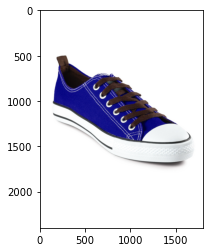

In [131]:
example_img_path = '../data/e-commerce-product-images/Footwear/Men/Images/images_with_product_ids/2089.jpg'

print('----- Selected Image: -----')
plt.imshow(cv2.imread(example_img_path))

----- Similar Images: -----


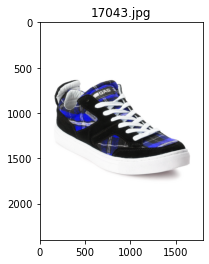

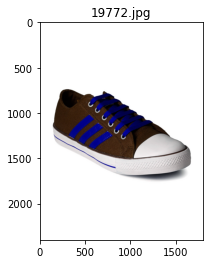

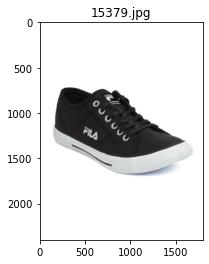

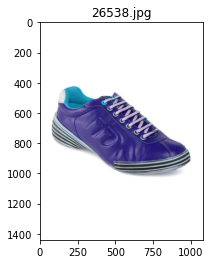

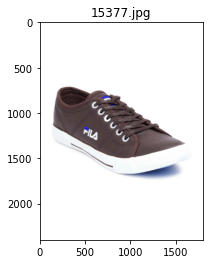

In [132]:
print('----- Similar Images: -----')
display_similar_images(example_img_path)